In [1]:
import os
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import pickle
import torch
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

In [2]:
def fetch_model(fpath):
    infile = open(fpath, 'rb')
    res_dict = pickle.load(infile)
    infile.close()
    return res_dict

In [3]:
def coef2matrix(coef, n_roi=192, top_coef_ratio=0.03):
    coef = coef.reshape(-1)
    n_top_coef = int(coef.shape[0] * top_coef_ratio)
    print(n_top_coef)
    idx_sorted = (-abs(coef)).argsort()
    coef_ = np.zeros(coef.shape)
    coef_[idx_sorted[:n_top_coef]] = coef[idx_sorted[:n_top_coef]]
    idx = np.triu_indices(n_roi, k=1)
    coef_matrix = np.zeros((n_roi, n_roi))
    coef_matrix[idx] = coef_[:]
    coef_matrix = coef_matrix.T
    coef_matrix[idx] = coef_[:]
    
    return coef_matrix

In [4]:
import seaborn as sns

def plot_tri_coef(coef_matrix, xlabels=False, ylabels=False, fig_name='figure.pdf', cmap='coolwarm'):
    mask = np.zeros_like(coef_matrix)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(16,12))
    sns.heatmap(data=coef_matrix, mask=mask, xticklabels=xlabels, yticklabels=ylabels, cmap=cmap)
    plt.yticks(fontsize=3)
    plt.xticks(fontsize=3)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [5]:
def cat_coef(res_dict, kernel_rev=False):
    coef_ = []
    for i in range(len(res_dict['clf'])):
        pca = res_dict['embed'][i]
        clf = res_dict['clf'][i]
        clf_coef = clf.coef_
        if kernel_rev:
            clf_coef = np.dot(clf_coef.T, clf._X)
        coef_.append(pca.inverse_transform(clf_coef).reshape((1, -1)))
        
    return np.concatenate(coef_, axis=0)

### AICHA Model

In [15]:
# redige coefficients
basedir = 'D:/ShareFolder/AICHA_VolFC/Result'
fname = 'intra_half_brain_Ridge_REST1_144.pickle'
# fname = 'intra_half_brain_Ridge_REST1_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))
ridge_coef = cat_coef(res_dict)

In [36]:
# regularised clf coefficients
basedir = 'D:/ShareFolder/AICHA_VolFC/Result'
# fname = 'intra_half_brain_SIDeRLS_REST1_144.pickle'
# fname = 'intra_half_brain_Ridge_REST1_144.pickle'
fname =  'intra_half_brain_SVC_REST1_LR_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))
sider_coef = cat_coef(res_dict)

In [37]:
from scipy.stats import pearsonr

corrs = []
for i in range(10):
    coef_i = ridge_coef[i, :]
    for j in range(10):
        coef_j = sider_coef[j, :]
        corr, _ = pearsonr(coef_i.reshape(-1), coef_j.reshape(-1))
        corrs.append(corr)
        print(corr)

0.8647510166402261
0.8651446054186045
0.8437044303181862
0.8374912044418097
0.8710054184975751
0.850399131778997
0.8622856164678376
0.8660035242510282
0.8419745663036243
0.8556501173289457
0.8628764471305692
0.8588365821712928
0.8464237171608358
0.83196671033154
0.8597168998716876
0.8406938755746942
0.8537188345914943
0.8592208306749681
0.8381443708929035
0.8612533031477312
0.8664925855943092
0.8711305600746732
0.8505240098841522
0.8881626194117508
0.8721092495956306
0.8663602407749613
0.8602557888421685
0.8676476191780229
0.8572080047787044
0.8799424204074004
0.8715835073012056
0.870051159629031
0.8655442206505191
0.897259936256267
0.8777526905786245
0.8692775583566157
0.8710748851335617
0.8677015990275834
0.8585039227646498
0.8873391246413938
0.8594732331637519
0.8679175536288505
0.860179061941527
0.8899474855599432
0.8706351180672776
0.8708287491130748
0.8687769147025071
0.8674462539179815
0.8672162305459468
0.8805353923596881
0.8701565101283515
0.8766313605596346
0.8583776631731129

In [38]:
np.mean(corrs)

0.8674589268048192

In [39]:
np.std(corrs)

0.011832011856053502

In [29]:
ridge_coef.shape

(10, 18336)

In [28]:
print(corr)

0.8352216802842669


In [7]:
import pandas as pd

roi_list_fpath = 'D:\ShareFolder\AICHA_VolFC\AtlasInfo\AICHA_ROI_MNI_V1.txt'

rois = pd.read_table(roi_list_fpath, header=None)
roi_list = list(rois.loc[0::2, 0])
sub_roi_names = [sub_roi.replace('-L', '') for sub_roi in roi_list]
roi_nams = [name.split('-')[0] for name in sub_roi_names]

In [ ]:
plot_tri_coef()

In [8]:
coef_all.shape

(10, 18336)

### BNA Model

In [3]:
basedir = 'D:/ShareFolder/BNA/Result'
fname = 'intra_half_brain_SVC_REST1_144.pickle'
res_dict = fetch_model(os.path.join(basedir, fname))

In [22]:
pca = res_dict['embed'][0]
clf = res_dict['clf'][0]
coef_ = pca.inverse_transform(clf.coef_)
coef_matrix = coef2matrix(coef_, n_roi=123)

225


In [23]:
import pandas as pd
import io_

roi_list_fpath = 'D:\ShareFolder\BNA\subregion_func_network.xlsx'

rois = io_.read_table(roi_list_fpath, sheet_name='Brainnetome')['region']
roi_list = list(rois.loc[0::2])
roi_names = [sub_roi.replace('_L', '') for sub_roi in roi_list]
# roi_nams = [name.split('-')[0] for name in sub_roi_names]

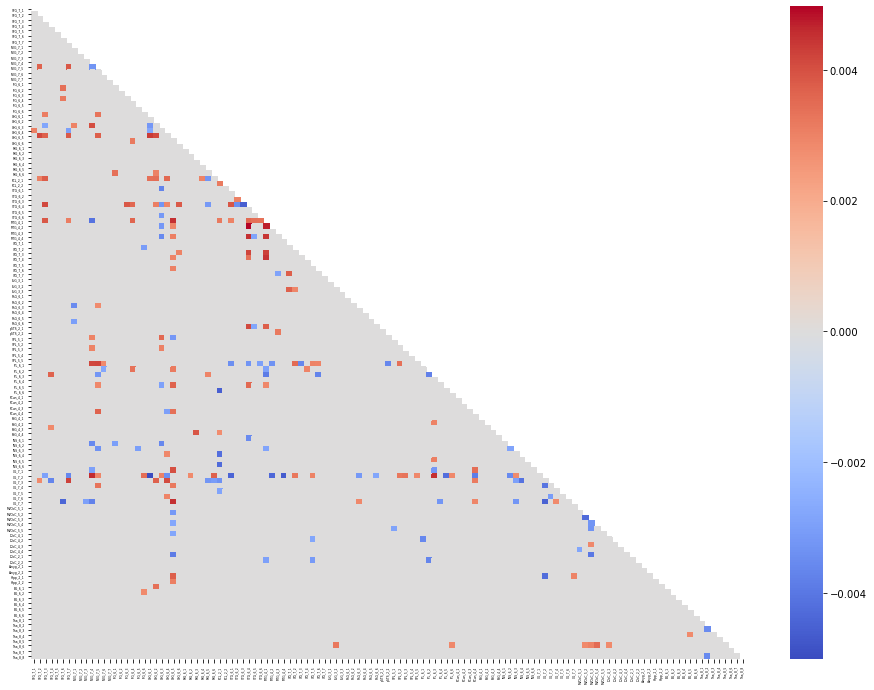

In [24]:
plot_tri_coef(coef_matrix, cmap='coolwarm', xlabels=roi_names, ylabels=roi_names, fig_name='BNA_SVC.pdf')

### Correlation analysis

In [19]:
res_dict

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9951690821256038, 1.0, 1.0, 1.0],
 'auc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'embed': [PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144),
  PCA(n_components=500, random_state=144)],
 'clf': [SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear'),
  SVC(C=1, kernel='linear')],
 'params': [{'PCA': {'n_components': 500},
   'clf': {'C': 1, 'kernel': 'linear'}},
  {'PCA': {'n_components': 500}, 'clf': {'C

In [20]:
pca1 = res_dict['embed'][3]
clf1 = res_dict['clf'][3]
coef1_ = pca1.inverse_transform(clf1.coef_)

In [21]:
from scipy.stats import pearsonr

corr, _ = pearsonr(coef_.reshape(-1), coef1_.reshape(-1))

In [22]:
corr

0.8571242875472798

In [35]:
coef_random0 = np.random.random(coef_.shape)
coef_random1 = np.random.random(coef_.shape)

corr, _ = pearsonr(coef_random0.reshape(-1), coef_random1.reshape(-1))

In [5]:
coef_matrix = coef2matrix(coef_)

916


In [5]:
def plot_coef(coef_matrix, xlabels=None, ylabels=None, cmap='gist_heat', fig_name='figure.pdf'):
    if xlabels is not None:
        plt.xticks(ticks=np.arange(len(xlabels)),labels=xlabels, rotation=90)
    if ylabels is not None:
        plt.yticks(ticks=np.arange(len(ylabels)),labels=ylabels)    
    plt.imshow(coef_matrix, cmap='cool',interpolation="nearest")
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [11]:
import seaborn as sns

def plot_coef(coef_matrix, xlabels=False, ylabels=False, fig_name='figure.pdf'):
    
    sns.heatmap(data=coef_matrix, xticklabels=xlabels, yticklabels=ylabels)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [56]:
import chart_studio.plotly as ply
import plotly.graph_objs as go

def make_layout(title, plot_size):
    axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

    return go.Layout(title=title,
                  xaxis=dict(axis),
                  yaxis=dict(axis),
                  showlegend=False,
                  width=plot_size,
                  height=plot_size,
                  margin=dict(t=25, b=25, l=25, r=25),
                  hovermode='closest',
                  shapes=[]# to this list one appends below the dicts defining the ribbon,
                           #respectively the ideogram shapes
                 )

In [ ]:
link = {'source': [], 'target': [], 'value': []}

for i in range(192):
    for j in range
    link['source'].append

In [14]:
coef_df = pd.DataFrame(data=coef_matrix, columns=roi_names)
coef_df.to_csv('Coef_matrix_sample1.csv', index=False)

In [ ]:
layout=make_layout('Chord diagram', 400)

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score
import io_

pca = res_dict['embed'][0]
clf = res_dict['clf'][0]

data_dir = 'D:/ShareFolder/AICHA_VolFC/Proc'
sessions = ['REST1', 'REST2']
runs = ['RL', 'LR']
connection_type = 'intra'
atlas = 'AICHA'
for session in sessions:
    for run_ in runs:
        data = io_.load_half_brain(data_dir, atlas, session, run_, connection_type)
        x_left = data['Left']
        y_pred = clf.predict(pca.transform(x_left))
        print(accuracy_score(np.ones(y_pred.shape), y_pred))
        
        x_right = data['Right']
        y_pred = clf.predict(pca.transform(x_right))
        print(accuracy_score(-1 * np.ones(y_pred.shape), y_pred))
        

0.9655831739961759
0.9933078393881453
1.0
1.0
0.9794661190965093
0.9856262833675564
1.0
1.0


In [10]:
model_dir = "/media/shuoz/MyDrive/data/HCP/BNA/Results/Rand_Half"
male_model1 = "model_REST1_0.pt"
male_model2 = "model_REST2_0.pt"
female_model1 = "model_REST1_1.pt"
female_model2 = "model_REST2_1.pt"

In [13]:
weight_1 = get_model_weight(female_model1, model_dir)
weight_2 = get_model_weight(female_model2, model_dir)

In [14]:
pearsonr(weight_1[:, 0], weight_2[:, 0])

(-0.39809138686131806, 2.111313188172552e-283)

In [5]:
rand_dir = '/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half'
ind_dir = '/media/shuoz/MyDrive/HCP/BNA/Results/IND_Half'
sub_dir = '/media/shuoz/MyDrive/HCP/BNA/Results/Sub_Half_Fisherz'
fix_dir = '/media/shuoz/MyDrive/HCP/BNA/Results/Fix_OC'

In [5]:
# sub_dir = '/media/shuoz/MyDrive/data/HCP/BNA/Models'
sub_dir = "D:/ShareFolder/BNA/Analysis/Models"

In [11]:
weight = []
gender_labels = []
splits = 5
halfs = [0, 1]
genders = [0, 1]
half = 0
genders = [0, 1]
lambda_ = 2.0

for gender in genders:
    for session_i in ['REST1', 'REST2']:
        for half_i in halfs:
            for i in range(splits):
                model_file = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half_i, gender)
                if os.path.exists(os.path.join(sub_dir, model_file)):
                    print(model_file)
                    weight.append(get_coef(model_file, sub_dir).reshape((1, -1)))
                    gender_labels.append(gender)

weight = np.concatenate(weight)
w_mean = np.mean(weight, axis=0)

lambda_2.0_REST1_0_0_gender_0.pt
lambda_2.0_REST1_1_0_gender_0.pt
lambda_2.0_REST1_2_0_gender_0.pt
lambda_2.0_REST1_3_0_gender_0.pt
lambda_2.0_REST1_4_0_gender_0.pt
lambda_2.0_REST1_0_1_gender_0.pt
lambda_2.0_REST1_1_1_gender_0.pt
lambda_2.0_REST1_2_1_gender_0.pt
lambda_2.0_REST1_3_1_gender_0.pt
lambda_2.0_REST1_4_1_gender_0.pt
lambda_2.0_REST2_0_0_gender_0.pt
lambda_2.0_REST2_1_0_gender_0.pt
lambda_2.0_REST2_2_0_gender_0.pt
lambda_2.0_REST2_3_0_gender_0.pt
lambda_2.0_REST2_4_0_gender_0.pt
lambda_2.0_REST2_0_1_gender_0.pt
lambda_2.0_REST2_1_1_gender_0.pt
lambda_2.0_REST2_2_1_gender_0.pt
lambda_2.0_REST2_3_1_gender_0.pt
lambda_2.0_REST2_4_1_gender_0.pt
lambda_2.0_REST1_0_0_gender_1.pt
lambda_2.0_REST1_1_0_gender_1.pt
lambda_2.0_REST1_2_0_gender_1.pt
lambda_2.0_REST1_3_0_gender_1.pt
lambda_2.0_REST1_4_0_gender_1.pt
lambda_2.0_REST1_0_1_gender_1.pt
lambda_2.0_REST1_1_1_gender_1.pt
lambda_2.0_REST1_2_1_gender_1.pt
lambda_2.0_REST1_3_1_gender_1.pt
lambda_2.0_REST1_4_1_gender_1.pt
lambda_2.0

In [12]:
weight.shape

(40, 7504)

In [8]:
weight_ = weight.copy()

In [13]:
from scipy.io import savemat

mdic = {"lambda_0": weight_, "lambda_2": weight}
savemat("model_weights.mat", mdic)

In [14]:
n_models = 40

corr_mat = np.ones((n_models, n_models))
corrs = []

for i in range(n_models):
    for j in range(n_models):
        if i != j:
            corr, _ = pearsonr(weight[i, ], weight[j, ])
            corr_mat[i, j] = corr

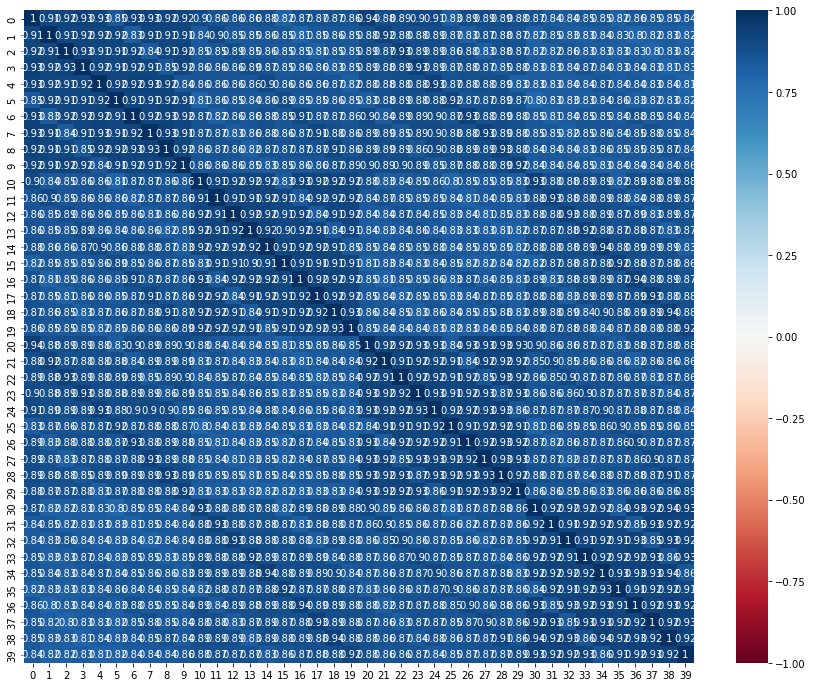

In [15]:
fig, ax = plt.subplots(figsize=(15,12)) 
ax = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, cmap='RdBu')

In [32]:
gender_labels

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [15]:
splits = 5
halfs = [0, 1]
genders = [0, 1]
half = 0
gender = 0
lambda_ = 0.0

corr_mat = np.ones((splits * 4, splits * 4))
corrs = []

row = 0
file_names = []
ws = []
for session_i in ['REST1', 'REST2']:
    for half_i in halfs:
        for i in range(splits):
            file_i = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half_i, gender)
            weight_i = get_model_weight(file_i, sub_dir)
            col = 0
            file_names.append(file_i)
            for session_j in ['REST1', 'REST2']:
                for half_j in halfs:
                    for j in range(splits):
                        file_j = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_j, j, half_j, gender)
                        if file_i == file_j:
                            col += 1
                            continue
                        else:
                            weight_j = get_model_weight(file_j, sub_dir)
                            corr, _ = pearsonr(weight_i[:, 0], weight_j[:, 0])
                            corr_mat[row, col] = corr
                            corrs.append(corr)
                            col += 1
                            print(file_i)
                            print(file_j)
                            print(corr)
            row += 1

lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_1_0_gender_0.pt
0.9528667365230732
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_2_0_gender_0.pt
0.95415639974497
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_3_0_gender_0.pt
0.9640453256315371
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_4_0_gender_0.pt
0.9534257737722107
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_0_1_gender_0.pt
0.9110855544109001
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_1_1_gender_0.pt
0.9586346851228522
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_2_1_gender_0.pt
0.9551144442211315
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_3_1_gender_0.pt
0.948476856580926
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_4_1_gender_0.pt
0.9549167234714562
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST2_0_0_gender_0.pt
0.9353349662813272
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST2_1_0_gender_0.pt
0.9276238171838789
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST2_2_0_gender_0.pt
0.

lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST1_2_1_gender_0.pt
0.9274365181954597
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST1_3_1_gender_0.pt
0.9361813785305931
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST1_4_1_gender_0.pt
0.9280542907179505
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_1_0_gender_0.pt
0.9576189808572566
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_2_0_gender_0.pt
0.9480702409048949
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_3_0_gender_0.pt
0.9582948594157363
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_4_0_gender_0.pt
0.9537589495768648
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_0_1_gender_0.pt
0.9123460789973568
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_1_1_gender_0.pt
0.9510919297265001
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_2_1_gender_0.pt
0.9629058967736087
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_3_1_gender_0.pt
0.9517677280909955
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_4_1_gender_0.pt

In [14]:
splits = 5
halfs = [0, 1]
genders = [0, 1]
half = 0
gender = 0
lambda_ = 1.0

# corr_mat = np.ones((splits * 4, splits * 4))
corrs = []

row = 0
for session_i in ['REST1', 'REST2']:
    for half_i in halfs:
        for i in range(splits):
            file_i = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half, gender)
            weight_i = get_model_weight(file_i, sub_dir)[:, 0]
            weight_i[np.where(np.abs(weight_i) < 0.04)] = 0
            for session_j in ['REST1', 'REST2']:
                for half_j in halfs:
                    col = 0
                    for j in range(splits):

                        file_j = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_j, j, half, gender)
                        if file_i == file_j:
                            col += 1
                            continue
                        else:
                            weight_j = get_model_weight(file_j, sub_dir)[:, 0]
                            weight_j[np.where(np.abs(weight_i) < 0.04)] = 0
                            corr, _ = pearsonr(weight_i, weight_j)
#                             corr_mat[row, col] = corr
                            corrs.append(corr)
                            col += 1
                            print(file_i)
                            print(file_j)
                            print(corr)
            row += 1

lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_1_0_gender_0.pt
0.9719906115565562
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_2_0_gender_0.pt
0.7594508119401568
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_3_0_gender_0.pt
0.9945849127469353
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_4_0_gender_0.pt
0.9788682353157075
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_1_0_gender_0.pt
0.9719906115565562
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_2_0_gender_0.pt
0.7594508119401568
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_3_0_gender_0.pt
0.9945849127469353
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST1_4_0_gender_0.pt
0.9788682353157075
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST2_0_0_gender_0.pt
0.9323238728397472
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST2_1_0_gender_0.pt
0.8113742282079841
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST2_2_0_gender_0.pt
0.9636248818122233
lambda_1.0_REST1_0_0_gender_0.pt
lambda_1.0_REST2_3_0_gender_0.pt

lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_1_0_gender_0.pt
0.9814603633629411
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_2_0_gender_0.pt
0.7804460785744479
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_3_0_gender_0.pt
0.9677908034593041
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_4_0_gender_0.pt
0.9847691380196181
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_1_0_gender_0.pt
0.9814603633629411
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_2_0_gender_0.pt
0.7804460785744479
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_3_0_gender_0.pt
0.9677908034593041
lambda_1.0_REST2_0_0_gender_0.pt
lambda_1.0_REST2_4_0_gender_0.pt
0.9847691380196181
lambda_1.0_REST2_1_0_gender_0.pt
lambda_1.0_REST1_0_0_gender_0.pt
0.74007405545917
lambda_1.0_REST2_1_0_gender_0.pt
lambda_1.0_REST1_1_0_gender_0.pt
0.9249534264240523
lambda_1.0_REST2_1_0_gender_0.pt
lambda_1.0_REST1_2_0_gender_0.pt
0.9754262877851851
lambda_1.0_REST2_1_0_gender_0.pt
lambda_1.0_REST1_3_0_gender_0.pt
0

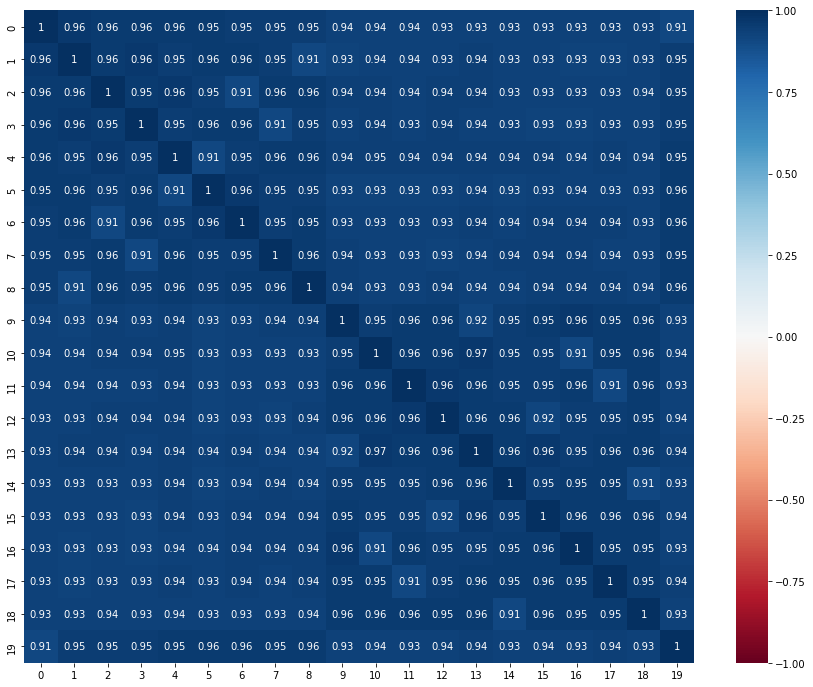

In [16]:
sort_idx = (-1 * corr_mat[14, :]).argsort()
fig, ax = plt.subplots(figsize=(15,12)) 
ax = sns.heatmap(corr_mat[sort_idx][:, sort_idx], vmin=-1, vmax=1, annot=True, cmap='RdBu')

In [120]:
np.asarray(file_names)[sort_idx]

array(['lambda_2.0_REST2_4_0_gender_1.pt',
       'lambda_2.0_REST2_1_0_gender_1.pt',
       'lambda_2.0_REST2_3_0_gender_1.pt',
       'lambda_2.0_REST2_2_1_gender_1.pt',
       'lambda_2.0_REST1_4_1_gender_1.pt',
       'lambda_2.0_REST1_1_0_gender_1.pt',
       'lambda_2.0_REST1_2_0_gender_1.pt',
       'lambda_2.0_REST1_2_1_gender_1.pt',
       'lambda_2.0_REST2_4_1_gender_1.pt',
       'lambda_2.0_REST1_4_0_gender_1.pt',
       'lambda_2.0_REST1_0_0_gender_1.pt',
       'lambda_2.0_REST1_3_0_gender_1.pt',
       'lambda_2.0_REST1_1_1_gender_1.pt',
       'lambda_2.0_REST2_2_0_gender_1.pt',
       'lambda_2.0_REST1_0_1_gender_1.pt',
       'lambda_2.0_REST1_3_1_gender_1.pt',
       'lambda_2.0_REST2_3_1_gender_1.pt',
       'lambda_2.0_REST2_1_1_gender_1.pt',
       'lambda_2.0_REST2_0_0_gender_1.pt',
       'lambda_2.0_REST2_0_1_gender_1.pt'], dtype='<U32')

In [17]:
weight = []
for model_file in np.asarray(file_names)[sort_idx]:
    print(model_file)
    w_ = get_model_weight(model_file, sub_dir)[:, 0].reshape(1, -1)
    weight.append(w_)

weight = np.concatenate(weight)
w_mean = np.mean(weight, axis=0)

lambda_0.0_REST2_4_0_gender_0.pt
lambda_0.0_REST2_3_0_gender_0.pt
lambda_0.0_REST2_2_0_gender_0.pt
lambda_0.0_REST2_1_0_gender_0.pt
lambda_0.0_REST2_0_1_gender_0.pt
lambda_0.0_REST2_0_0_gender_0.pt
lambda_0.0_REST2_2_1_gender_0.pt
lambda_0.0_REST2_1_1_gender_0.pt
lambda_0.0_REST2_3_1_gender_0.pt
lambda_0.0_REST1_3_0_gender_0.pt
lambda_0.0_REST1_0_1_gender_0.pt
lambda_0.0_REST1_2_1_gender_0.pt
lambda_0.0_REST1_1_0_gender_0.pt
lambda_0.0_REST1_3_1_gender_0.pt
lambda_0.0_REST1_4_1_gender_0.pt
lambda_0.0_REST1_1_1_gender_0.pt
lambda_0.0_REST1_0_0_gender_0.pt
lambda_0.0_REST1_2_0_gender_0.pt
lambda_0.0_REST1_4_0_gender_0.pt
lambda_0.0_REST2_4_1_gender_0.pt


In [13]:
# weight = {"REST1_0"}
models = ["REST1_0", "REST1_1", "REST2_0", "REST2_1"]
mdic = dict()
for model in models:
    mdic[model] = get_model_weight("model_%s.pt" % model, "D:\ShareFolder\BNA\Result")[:, 0].reshape(1, -1)


In [11]:
mdic

{'REST1_0': array([[ 0.05619045,  0.08969803,  0.01697333, ...,  0.02476346,
         -0.00053791,  0.00060103]], dtype=float32),
 'REST1_1': array([[ 0.05837349,  0.0556205 ,  0.00193159, ...,  0.00930105,
         -0.00375327, -0.0121294 ]], dtype=float32),
 'REST2_0': array([[ 0.05998529, -0.02345737, -0.08157925, ..., -0.03417065,
         -0.05096567, -0.01382918]], dtype=float32),
 'REST2_1': array([[ 0.0723104 , -0.01946526, -0.09715977, ..., -0.0357911 ,
         -0.0413949 , -0.0093546 ]], dtype=float32)}

In [18]:
weight.shape

(20, 7503)

In [123]:
type(weight)

numpy.ndarray

In [7]:
from scipy.io import savemat

In [14]:
# mdic = {"weights": weights}
savemat("model_weights.mat", mdic)

In [125]:
savemat("matlab_matrix.mat", mdic)

In [58]:
w2 = get_model_weight(model_file, sub_dir)[:, 1]

In [108]:
pred = torch.sigmoid(torch.from_numpy(np.dot(x, w_mean))).numpy()
y_pred = prob2label(pred)

In [102]:
pred_ = torch.sigmoid(torch.from_numpy(np.dot(x, w1))).numpy()

In [62]:
pred_

array([0.19092312, 0.938666  , 0.04380769, ..., 0.02266825, 0.2393961 ,
       0.0981056 ])

In [59]:
pred = torch.sigmoid(torch.from_numpy(np.dot(x, w2))).numpy()

In [60]:
pred

array([9.15256417e-01, 1.75434251e-04, 9.96646187e-01, ...,
       9.98154864e-01, 5.61346203e-02, 9.75472673e-01])

In [63]:
pred + pred_

array([1.10617954, 0.93884144, 1.04045388, ..., 1.02082312, 0.29553072,
       1.07357827])

In [ ]:
pred_ = torch.sigmoid(torch.from_numpy(np.dot(x, weight[2]))).numpy()

In [109]:
print(accuracy_score(y[idx_female], y_pred[idx_female]))
print(accuracy_score(y[idx_male], y_pred[idx_male]))

0.7158081705150977
0.9595744680851064


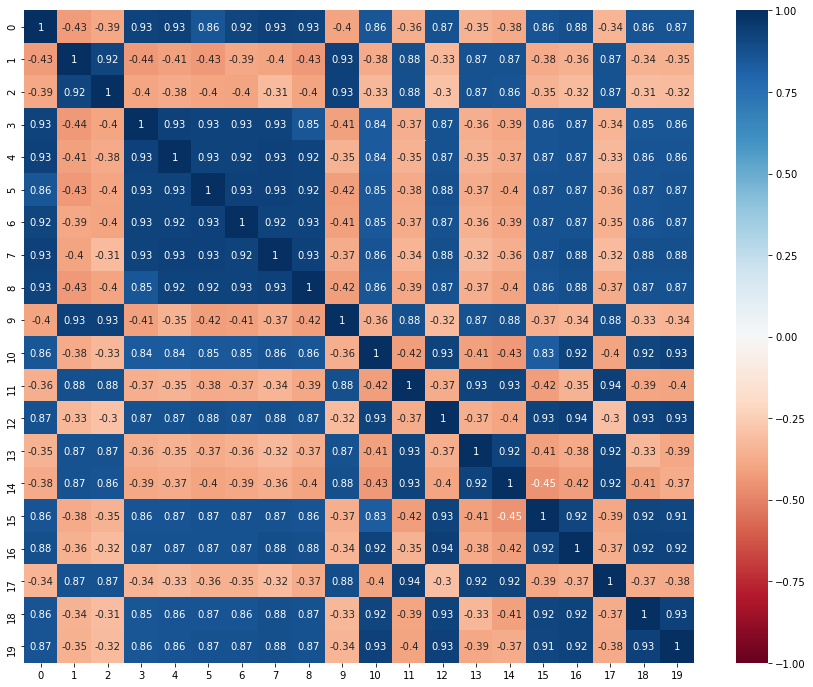

In [118]:
fig, ax = plt.subplots(figsize=(15,12)) 
ax = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, cmap='RdBu')

In [2]:
def prob2label(prob):
    prob_ = prob.copy()
    prob_[np.where(prob<0.5)] = 0
    prob_[np.where(prob>0.5)] = 1
    return prob_

In [3]:
def get_model_weight(file_name, file_dir):
    file_path = os.path.join(file_dir, file_name)
    model = torch.load(file_path)
    return model.model.weight.data.numpy().T

def get_coef(file_name, file_dir):
    file_path = os.path.join(file_dir, file_name)
    model = torch.load(file_path)
    return model.theta

In [4]:
def weight_threshold(w, threshold):
    w_new = w.copy()
    w_new[np.where(np.abs(w)<threshold)] = 0
    return w_new

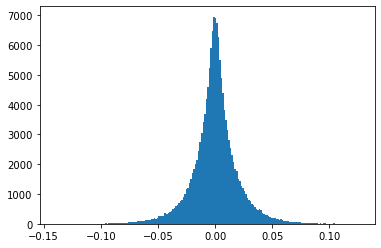

In [110]:
splits = 5
halfs = [0, 1]
genders = [0, 1]
half = 0
gender = 1
lambda_ = 1.0
weights = []
for session_i in ['REST1', 'REST2']:
    for half_i in halfs:
        for i in range(splits):
#             file_i = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half_i, gender)
            file_i = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half_i, gender)
            weight = get_model_weight(file_i, sub_dir)
            weights.append(weight[:, 0])
#             plt.hist(weight, bins=100)
#             plt.show()
weights = np.concatenate(weights)
plt.hist(weights, bins=200)
plt.show()

In [114]:
sub_dir = '/media/shuoz/MyDrive/HCP/BNA/Results/Sub_Half'

splits = 5
halfs = [0, 1]
genders = [0, 1]
half = 0
gender = 1
lambda_ = 1.0
weights = []
for session_i in ['REST1', 'REST2']:
    for half_i in halfs:
        for i in range(splits):
            file_i = 'lambda_%s_%s_%s_%s_gender_%s.pt' % (lambda_, session_i, i, half_i, gender)
            weight = get_model_weight(file_i, sub_dir)
            weights.append(weight[:, 0].reshape(1, -1))
weights = np.concatenate(weights)

In [115]:
weights_mean = np.mean(weights, axis=0)
w_std = np.std(weights, axis=0)

In [12]:
weights_mean_thre = weights_mean.copy()
weights_mean_thre[np.where(np.abs(weights_mean_thre)<0.022)] = 0

In [40]:
w_mean_thre = weights_mean.copy()
w_mean_thre[np.where(np.abs(w_std)>0.003)] = 0

In [116]:
w_std.shape

(7503,)

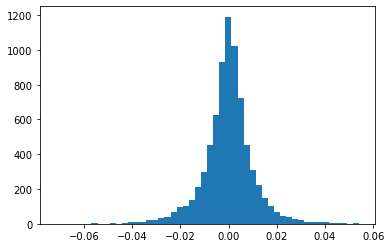

In [117]:
plt.hist(weights_mean, bins=50)
plt.show()

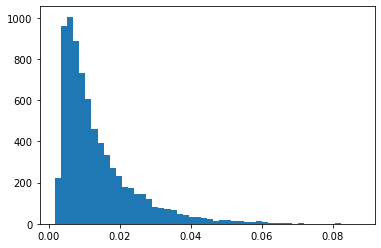

In [121]:
plt.hist(w_std, bins=50)
plt.show()

In [118]:
weights_mean

array([-0.03214842, -0.01287848,  0.02396869, ...,  0.00867555,
        0.0092159 ,  0.00412023], dtype=float32)

In [119]:
np.std(weights_mean)

0.0102899475

In [ ]:
plt.hist(weights_mean, bins=50)
plt.show()

In [120]:
np.std(weights_mean)

0.0102899475

In [41]:
pred_mean_thre = torch.sigmoid(torch.from_numpy(np.dot(x, w_mean_thre))).numpy()
pred_mean_thre_ = prob2label(pred_mean_thre)

In [42]:
print(accuracy_score(y[idx_female], pred_mean_thre_[idx_female]))
print(accuracy_score(y[idx_male], pred_mean_thre_[idx_male]))

0.8703374777975134
0.8595744680851064


In [5]:
from _base import _pick_half
from sklearn.preprocessing import label_binarize
import torch
import io_

In [21]:
atlas = 'BNA'
run_ = 'Fisherz'
session = 'REST1'
connection_type = 'intra'
random_state = 144
data_dir = "/media/shuoz/MyDrive/HCP/%s/Proc" % atlas
out_dir = '/media/shuoz/MyDrive/HCP/%s/Results/Sub_Half_%s' % (atlas, run_)
info_file = 'HCP_%s_half_brain_%s.csv' % (atlas, session)
info = io_.read_table(os.path.join(data_dir, info_file), index_col='ID')
data = io_.load_half_brain(data_dir, atlas, session, run_, connection_type)

genders = info['gender'].values
idx_male = np.where(genders == 0)[0]
idx_female = np.where(genders == 1)[0]

x, y, x1, y1 = _pick_half(data, random_state=random_state)

y = label_binarize(y, classes=[-1, 1]).reshape(-1)
y1 = label_binarize(y1, classes=[-1, 1]).reshape(-1)

In [136]:
w1 = get_model_weight('lambda_1.0_REST1_3_0_gender_0.pt', sub_dir)[:, 0]
w2 = get_model_weight('lambda_1.0_REST2_4_0_gender_0.pt', sub_dir)[:, 0]

In [155]:
w1[np.where(np.abs(w1)<0.04)] = 0
w2[np.where(np.abs(w2)<0.04)] = 0

In [156]:
pred1 = torch.sigmoid(torch.from_numpy(np.dot(x, w1))).numpy()
pred_1 = prob2label(pred1)

pred2 = torch.sigmoid(torch.from_numpy(np.dot(x, w2))).numpy()
pred_2 = prob2label(pred2)

In [147]:
torch.sigmoid(torch.from_numpy(np.dot(x, w1)))

tensor([0.1449, 0.9961, 0.0148,  ..., 0.0129, 0.8024, 0.0896],
       dtype=torch.float64)

In [157]:
print(accuracy_score(y[idx_female], pred_1[idx_female]))
print(accuracy_score(y[idx_male], pred_1[idx_male]))

0.8383658969804618
0.8042553191489362


In [158]:
print(accuracy_score(y[idx_female], pred_2[idx_female]))
print(accuracy_score(y[idx_male], pred_2[idx_male]))

0.9360568383658969
0.8659574468085106


In [154]:
print(accuracy_score(y[idx_female], pred_mean[idx_female]))
print(accuracy_score(y[idx_male], pred_mean[idx_male]))

1.0
1.0


In [153]:
pred_mean = torch.sigmoid(torch.from_numpy(np.dot(x, weights_mean))).numpy()
pred_mean = prob2label(pred_mean)

In [130]:
pred_2

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [111]:
y

array([1, 0, 1, ..., 1, 1, 1])

In [112]:
pred_1

tensor([0., 1., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [88]:
weights_mean = np.mean(weights, axis=0)

In [65]:
np.mean(weights)

0.00016119481

In [66]:
np.std(weights)

0.021695133

(array([[ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,
          0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  1.,  0.,  0.,  2.,  1.,  1.,  0.,  1.,  3.,  2.,  4.,  2.,
          3.,  8.,  5., 10., 12., 15., 25., 27., 43., 45., 43., 43., 44.,
         39., 19., 20., 12.,  8.,  5.,  7.,  1.,  2.,  5.,  5.,  1.,  0.,
          0.,  1.,  3.,  3.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  3.,
          0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
          0.,  0.,  1.,  0.,  2.,  2.,  1.,  0.,  1.,  2.,  0.,  1.,  1.,
          1.,  1.,  1.,  0.,  4.,  0.,  0.,  1.,  2.,  2.,  7.,  1.,  2.,
          4.,  4.,  6.,  6., 11., 18., 20., 36., 39., 47., 41., 42., 37.,
         32., 27., 15., 12., 11., 10.,  6.,  4.,  4.,  4.,  2.,  1.,  2.,
          2.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.

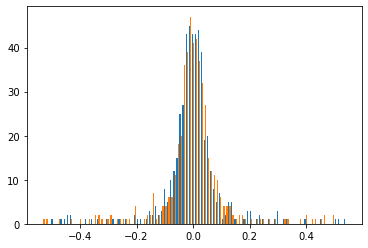

In [50]:
plt.hist(weight_i, bins=100)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 360.]),
 array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
        -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
         0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ]),
 <BarContainer object of 25 artists>)

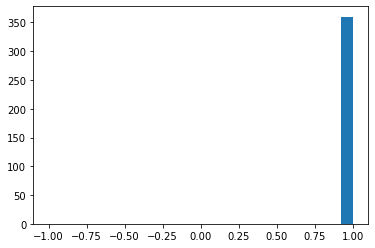

In [84]:
plt.hist(corrs, bins=25, range=(-1, 1))

(array([  4.,   0.,   0.,   0.,   0.,  16.,  28.,  64., 132., 116.]),
 array([0.97437864, 0.97687245, 0.97936626, 0.98186007, 0.98435388,
        0.98684769, 0.9893415 , 0.99183531, 0.99432912, 0.99682294,
        0.99931675]),
 <BarContainer object of 10 artists>)

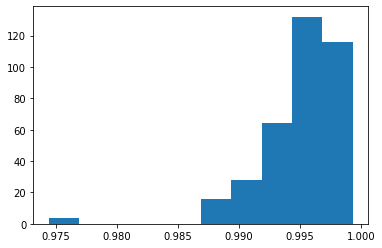

In [85]:
plt.hist(corrs)

In [33]:
len(corrs)

360

In [91]:
np.mean(corrs)

0.2791727883490044

In [92]:
len(corrs)

400

In [11]:
import os
import torch
from scipy.stats import pearsonr

lambdas = [1.0, 2.0, 5.0, 8.0, 10.0]
genders = [0, 1]
rand_splits = [0, 1, 2, 3, 4]
corrs = []

lambda_ = 1.0
gender = 0

for split in rand_splits:
    rand_model_file = 'rand_half_lambda_%s_test_%s_gender_%s.pt' % (lambda_, split, gender)
    rand_model_path = os.path.join(rand_dir, rand_model_file)    
    model_rand = torch.load(rand_model_path)
    
    for ind_split in [0, 1]:
        ind_model_file = 'lambda_%s_test_%s_gender_%s.pt' % (lambda_, ind_split, gender)
        ind_model_path = os.path.join(ind_dir, ind_model_file)    
        model_ind = torch.load(ind_model_path)

        corr, _ = pearsonr(model_rand.model.weight.data.numpy().T[:, 0], 
                           model_ind.model.weight.data.numpy().T[:, 0])
        
        corrs.append(corr)
# corr, _ = pearsonr(model.weight.data.numpy().T[:, 0], log_reg.weight.data.numpy().T[:, 0])

In [10]:
corrs

[0.6373856545068739,
 0.8842265120163431,
 -0.4780962572829357,
 0.5063204472048419,
 0.8715218432271452,
 0.3453616617015646,
 0.06764275884924889,
 0.8950136404930806,
 0.3316219757543387,
 0.954622459884883]

In [12]:
corrs

[0.6583145734969678,
 0.5355813326845964,
 0.825920336265305,
 -0.42731829421636824,
 0.611338410678699,
 0.5833261319648024,
 0.8844762525228081,
 -0.2646175434376784,
 0.8229522830341625,
 -0.41908577297278854]

In [73]:
lambda_ = 0.0
gender = 1

In [55]:
import numpy as np

In [74]:
n_model = len(rand_splits)
corr_mat = np.ones((n_model, n_model))
for i in range(len(rand_splits)):
    split_i = rand_splits[i]
    model_i_file = 'rand_half_lambda_%s_test_%s_gender_%s.pt' % (lambda_, split_i, gender)
    model_i_path = os.path.join(rand_dir, model_i_file) 
    
    model_i = torch.load(model_i_path)
    for j in range(i+1, len(rand_splits)):
        split_j = rand_splits[j]
        model_j_file = 'rand_half_lambda_%s_test_%s_gender_%s.pt' % (lambda_, split_j, gender)
        model_j_path = os.path.join(rand_dir, model_j_file)
        print(model_i_path)
        print(model_j_path)
        model_j = torch.load(model_j_path)
        corr, _ = pearsonr(model_i.model.weight.data.numpy().T[:, 0], 
                           model_j.model.weight.data.numpy().T[:, 0])
        corr_mat[i, j] = corr
        corr_mat[j, i] = corr
        print(corr)

/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_0_gender_1.pt
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_1_gender_1.pt
0.9725907834264225
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_0_gender_1.pt
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_2_gender_1.pt
0.9730109133442503
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_0_gender_1.pt
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_3_gender_1.pt
0.9785260535922544
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_0_gender_1.pt
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_4_gender_1.pt
0.9761519819208606
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_1_gender_1.pt
/media/shuoz/MyDrive/HCP/BNA/Results/Rand_Half/rand_half_lambda_0.0_test_2_gender_1.pt
0.9723909667488008
/media/shuoz/MyDrive/HCP/BNA/Result

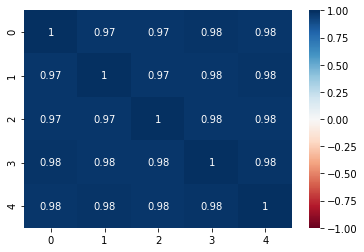

In [76]:


ax = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, cmap='RdBu')

In [35]:
weight_a = get_model_weight(model_a_file, ind_dir)

In [37]:
weight_a[:, 0].shape

(7503,)

In [19]:
model_a_file = 'lambda_%s_test_%s_gender_%s.pt' % (lambda_, 0, gender)
model_b_file = 'lambda_%s_test_%s_gender_%s.pt' % (lambda_, 1, gender)
model_a_path = os.path.join(ind_dir, model_a_file)
model_b_path = os.path.join(ind_dir, model_b_file)
model_a = torch.load(model_a_path)
model_b = torch.load(model_b_path)

half_splits = range(5)

corr, _ = pearsonr(model_a.model.weight.data.numpy().T[:, 0], 
                   model_b.model.weight.data.numpy().T[:, 0])

In [20]:
corr

0.31951756930370495